## 1. Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import chi2_contingency, f_oneway, shapiro, spearmanr

## 2. Reading the Training Data

- We will perform EDA only on training data to ensure that there is no data leakage

In [2]:
Project_Dir = "D:\FLIGHT_PRICE_PREDICTION"
Data_Dir = "DATA"

In [3]:
# Function to load Data
def get_data(name):
    filename = f"{name}.csv"
    filepath = os.path.join(Project_Dir,Data_Dir,filename)
    return pd.read_csv(filepath)
train_data = get_data('train')
train_data.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-04-01,Kolkata,Banglore,16:45:00,23:15:00,1830,3,No Info,8607
1,Multiple Carriers,2019-06-01,Delhi,Cochin,13:00:00,21:00:00,480,1,No Info,13587
2,Jet Airways,2019-05-21,Kolkata,Banglore,14:05:00,23:35:00,570,1,In-flight meal not included,10844
3,Jet Airways,2019-03-09,Delhi,Cochin,05:25:00,04:25:00,1380,2,No Info,16914
4,Jet Airways,2019-05-18,Kolkata,Banglore,16:30:00,08:15:00,945,1,In-flight meal not included,8586


### 2.1 Fixing Datatypes

In [4]:
train_data.dtypes

airline            object
date_of_journey    object
source             object
destination        object
dep_time           object
arrival_time       object
duration            int64
total_stops         int64
additional_info    object
price               int64
dtype: object

- Datatype of "date_of_journey" and "total_stops" should be fixed

In [5]:
# Function to fix datatype
def fix_dtype(df):
    return (
            df
            .assign(
                date_of_journey = lambda df_ : pd.to_datetime(df_.date_of_journey,yearfirst = True),
                total_stops = lambda df_ : df_.total_stops.astype(object)
            )
        )

In [6]:
train_fixed = fix_dtype(train_data)
train_fixed.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time                   object
arrival_time               object
duration                    int64
total_stops                object
additional_info            object
price                       int64
dtype: object

## 3. High Level Summary

In [7]:
# Checking non null values and datatype
train_fixed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7323 entries, 0 to 7322
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          7323 non-null   object        
 1   date_of_journey  7323 non-null   datetime64[ns]
 2   source           7323 non-null   object        
 3   destination      7323 non-null   object        
 4   dep_time         7323 non-null   object        
 5   arrival_time     7323 non-null   object        
 6   duration         7323 non-null   int64         
 7   total_stops      7323 non-null   object        
 8   additional_info  7323 non-null   object        
 9   price            7323 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 572.2+ KB


- There is no missing value

In [8]:
# Viewing statistical measures for numerical columns
train_fixed.describe(include="number")

,duration,price
count,7323.000000,7323.000000
mean,630.157039,9052.398197
std,497.235566,4663.010131
min,75.000000,1759.000000
25%,170.000000,5224.000000
50%,510.000000,8330.000000
75%,910.000000,12373.000000
max,2860.000000,79512.000000


In [9]:
# Viewing statistical measures for categorical columns
train_fixed.describe(include="O")

,airline,source,destination,dep_time,arrival_time,total_stops,additional_info
count,7323,7323,7323,7323,7323,7323,7323
unique,8,5,6,219,221,4,9
top,Jet Airways,Delhi,Cochin,18:55:00,19:00:00,1,No Info
freq,2580,3024,3024,167,421,3939,5761


## 4. High Level Analysis of Outliers

- We will find outliers using Isolation Forest model which returns -1 for outliers

In [10]:
outliers = IsolationForest(random_state=42,n_jobs=-1)

In [11]:
(
    train_fixed
    .assign(outlier = outliers.fit_predict(
        train_fixed
        .drop(columns="price")
        .select_dtypes(include="number")
    )
           )
    .query("outlier == -1")
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
0,Air India,2019-04-01,Kolkata,Banglore,16:45:00,23:15:00,1830,3,No Info,8607,-1
3,Jet Airways,2019-03-09,Delhi,Cochin,05:25:00,04:25:00,1380,2,No Info,16914,-1
4,Jet Airways,2019-05-18,Kolkata,Banglore,16:30:00,08:15:00,945,1,In-flight meal not included,8586,-1
5,Jet Airways,2019-06-03,Delhi,Cochin,10:00:00,04:25:00,1105,1,In-flight meal not included,11627,-1
7,Spicejet,2019-05-18,Chennai,Kolkata,09:45:00,12:00:00,135,0,No check-in baggage included,3543,-1
...,...,...,...,...,...,...,...,...,...,...,...
7317,Jet Airways,2019-03-12,Banglore,New Delhi,05:45:00,12:15:00,390,1,No Info,17524,-1
7319,Jet Airways,2019-03-21,Banglore,New Delhi,07:00:00,21:20:00,860,1,In-flight meal not included,7832,-1
7320,Indigo,2019-04-03,Delhi,Cochin,10:35:00,15:35:00,300,1,No Info,5073,-1
7321,Indigo,2019-04-27,Delhi,Cochin,05:35:00,08:50:00,195,0,No Info,6015,-1


- It is showing 3067 outliers based on "duration". We will do in depth analysis regarding outliers later

## 5. Correlation Analysis

<Axes: >

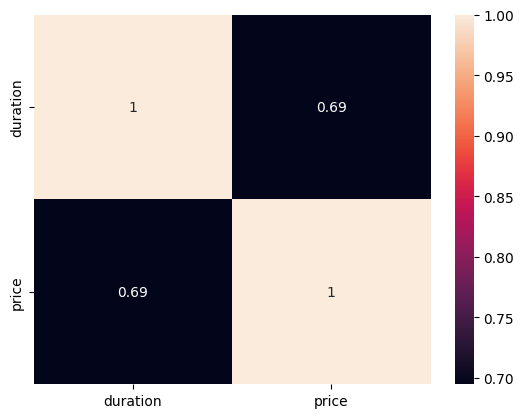

In [12]:
#Correlation for numeric columns
sns.heatmap(train_fixed.corr(method="spearman",numeric_only=True),annot=True)

<Axes: >

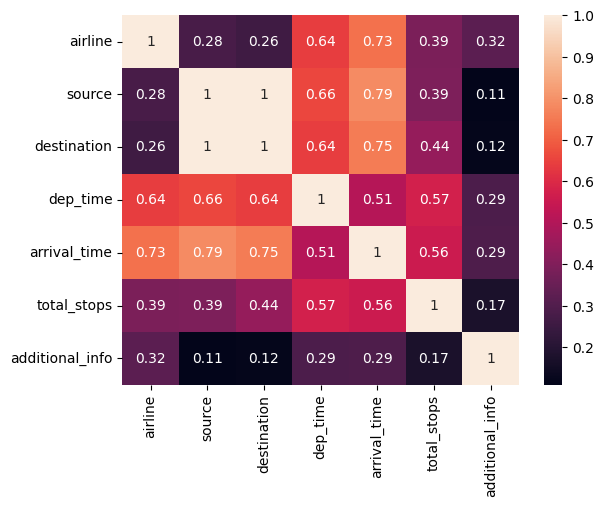

In [13]:
# Correlation for categorical column using Cramers's V

def cramers_V(data,var1,var2):
  contingency = pd.crosstab(
        data.loc[:,var1],data.loc[:,var2]
    )
  r, c = contingency.shape
  n = contingency.sum().sum()
  chi2 = chi2_contingency(contingency).statistic
  phi2 = chi2 / n

  # bias correction
  phi2_ = max(0, phi2 - ((r - 1) * (c - 1) / (n - 1)))
  r_ = r - (((r - 1) ** 2) / (n - 1))
  c_ = c - (((c - 1) ** 2) / (n - 1))

  return np.sqrt(phi2_ / min(r_ - 1, c_ - 1))

def cramers_V_df(data):
    cols = train_fixed.select_dtypes(include='O').columns.to_list()
    cramersV_table = (
        pd
        .DataFrame(data=np.ones((len(cols),len(cols))))
        .set_axis(cols,axis=0)
        .set_axis(cols,axis=1)
    )
    
    for col1 in cols:
        for col2 in cols:
            if col1 != col2:
                cramersV_table.loc[col1,col2] = cramers_V(data,col1,col2)
    return sns.heatmap(cramersV_table,annot=True)

cramers_V_df(train_fixed)

## 6. Detailed Analysis

In [14]:
train_fixed.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

### Functions for different analysis and hypothesis testing

In [15]:
# Function for univariate analysis of categorical column
def cat_univariate_plot(data,cat_var,fig_size=(10,5)):
    plt.figure(figsize=fig_size)
    ax = data[cat_var].value_counts().plot(kind='bar')
    ax.set_xticklabels(
    ax.get_xticklabels(), rotation = 30
    )


# Function for univariate analysis of numerical column
def num_univariate_plots(data,num_var,fig_size=(10,12)):
    fig, ax = plt.subplots(2,1,figsize=fig_size)
    sns.histplot(data,x=num_var,ax=ax[0])
    sns.boxplot(data,x=num_var,ax=ax[1])
    ax[0].set(title = "Histogram")
    ax[1].set(title = "Box Plot")


# Function for multivariate analysis between categorical and numerical columns
def num_cat_bivariate_plots(data,num_var,cat_var,fig_size=(15,18)):
    fig, ax = plt.subplots(3,1,figsize = fig_size)
    sns.barplot(data,x=cat_var,y=num_var,ax=ax[0])
    sns.violinplot(data,x=cat_var,y=num_var,ax=ax[1])
    sns.boxplot(data,x=cat_var,y=num_var,ax=ax[2])
    ax[0].set(title="Bar Plot")
    ax[1].set(title="Violin Plot")
    ax[2].set(title="Box Plot")


# Function for Anova test
def anova_test(data,num_var,cat_var,alpha=0.05):
    group_df = (
    data
    .dropna(subset=[num_var])
    .groupby(cat_var)
    )
    groups = [group[num_var].values for _, group in group_df]
    
    anova = f_oneway(*groups)
    pvalue = anova[1]
    print('Significance Level :',alpha*100,'%' )
    print("Null Hypothesis : The groups have similar population mean")
    print("Alternate Hypothesis : The groups don't have similar population mean")
    print('p-value :', pvalue)
    if pvalue < alpha:
        print(f"Since p-value is less than {alpha}, we Reject the Null Hypothesis at {alpha * 100}% significance level")
        print(f"CONCLUSION: The variables {num_var} and {cat_var} are associated to each other")
    else:
        print(f"Since p-value is greater than {alpha}, we Fail to Reject the Null Hypothesis at {alpha * 100}% significance level")
        print(f"CONCLUSION: The variables {num_var} and {cat_var} are not associated to each other")


# Function for Shapiro-Wilk test
def shapiro_wilk_test(data,var,alpha=0.05):
    col = data.loc[:,var].copy()
    sw_test = shapiro(col.dropna().values)
    sw_pvalue = sw_test.pvalue
    print('Significance Level :' ,alpha)
    print("Null Hypothesis : The data is normally distributed")
    print("Alternate Hypothesis : The data is not normally distributed")
    print('p-value :', sw_pvalue)
    if sw_pvalue < alpha:
        print(f"Since p-value is less than {alpha}, we Reject the Null Hypothesis at {alpha * 100}% significance level")
        print("CONCLUSION: We conclude that the data sample is not normally distributed")
    else:
        print(f"Since p-value is greater than {alpha}, we Fail to Reject the Null Hypothesis at {alpha * 100}% significance level")
        print("CONCLUSION: We conclude that the data sample is normally distributed")


# Function for Spearman test
def spearman_test(data,num_var1,num_var2,alpha=0.05):
    temp = (
        data
        .dropna(subset=[num_var1,num_var2], how='any')
        .copy()
    )
    spearman = spearmanr(temp[num_var1].values, temp[num_var2].values)
    pvalue = spearman.pvalue
    print('Significance Level :',alpha)
    print("Null Hypothesis : The samples are uncorrelated")
    print("Alternate Hypothesis : The samples are correlated")
    print('p-value :',pvalue)
    if pvalue < alpha:
        print(f"Since p-value is less than {alpha}, we Reject the Null Hypothesis at {alpha * 100}% significance level")
        print(f"CONCLUSION: The variables {num_var1} and {num_var2} are correlated")
    else:
        print(f"Since p-value is greater than {alpha}, we Fail to Reject the Null Hypothesis at {alpha * 100}% significance level")
        print(f"CONCLUSION: The variables {num_var1} and {num_var2} are uncorrelated")

### 6.1 Airline

In [16]:
# Category distribution
train_fixed.airline.value_counts(normalize=True)

airline
Jet Airways          0.352315
Indigo               0.193636
Air India            0.162638
Multiple Carriers    0.115253
Spicejet             0.077291
Vistara              0.048341
Air Asia             0.031818
Goair                0.018708
Name: proportion, dtype: float64

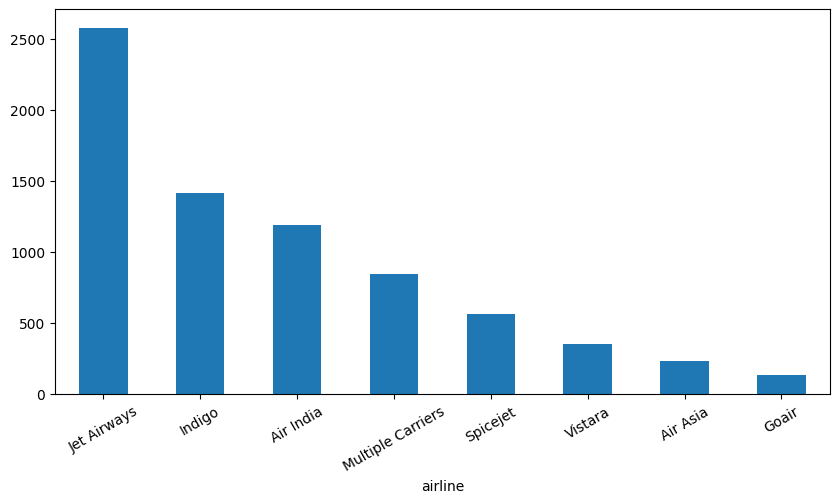

In [17]:
# Univariate analysis
cat_univariate_plot(train_fixed,'airline')

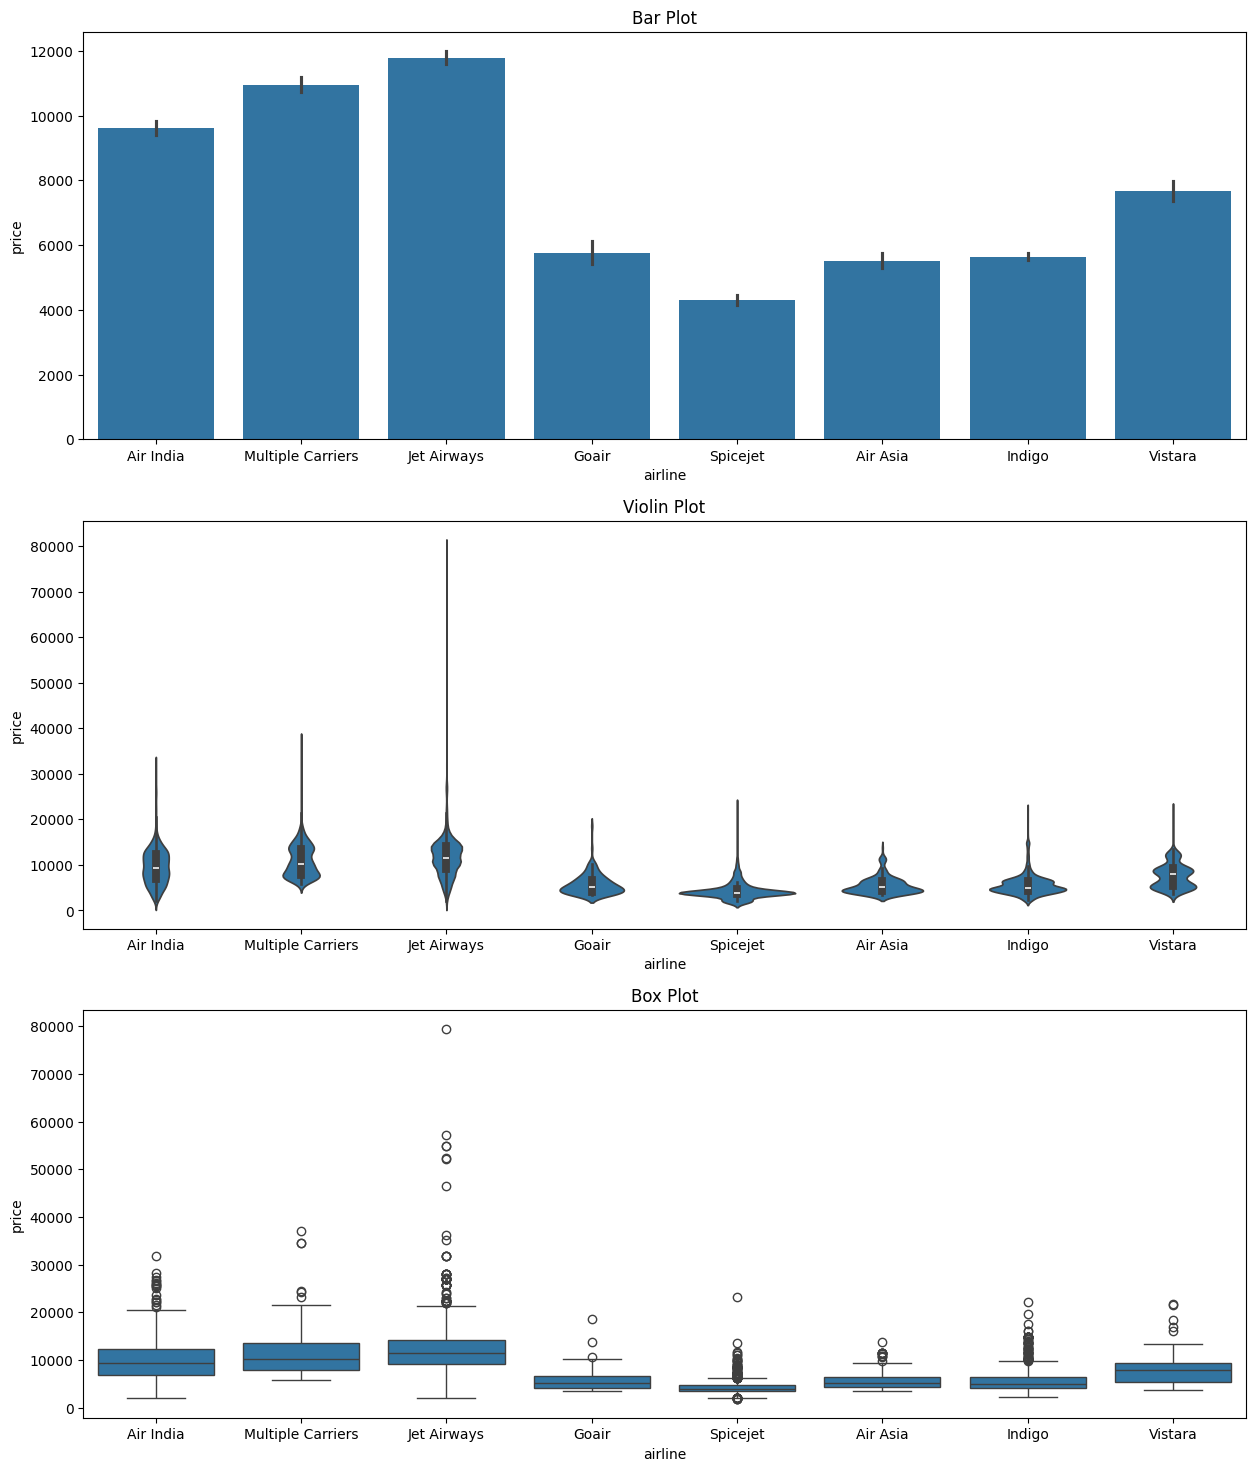

In [18]:
# Bivariate analysis between "airline" and "price"
num_cat_bivariate_plots(train_fixed,'price','airline')

- "airline" is a good feature to predict "price" as different category shows variation in price which means they may be associated
- There are some potential outliers

In [19]:
# Anova test 
anova_test(train_fixed,'price','airline')

Significance Level : 5.0 %
Null Hypothesis : The groups have similar population mean
Alternate Hypothesis : The groups don't have similar population mean
p-value : 0.0
Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
CONCLUSION: The variables price and airline are associated to each other


### 6.2 Source

In [20]:
# Category distribution
train_fixed.source.value_counts(normalize=True)

source
Delhi       0.412946
Kolkata     0.273795
Banglore    0.210160
Mumbai      0.067186
Chennai     0.035914
Name: proportion, dtype: float64

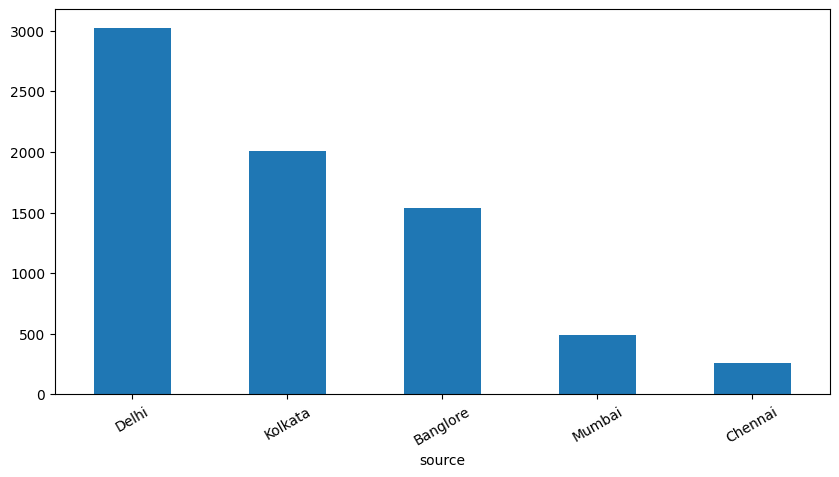

In [21]:
# Univariate plot
cat_univariate_plot(train_fixed,'source')

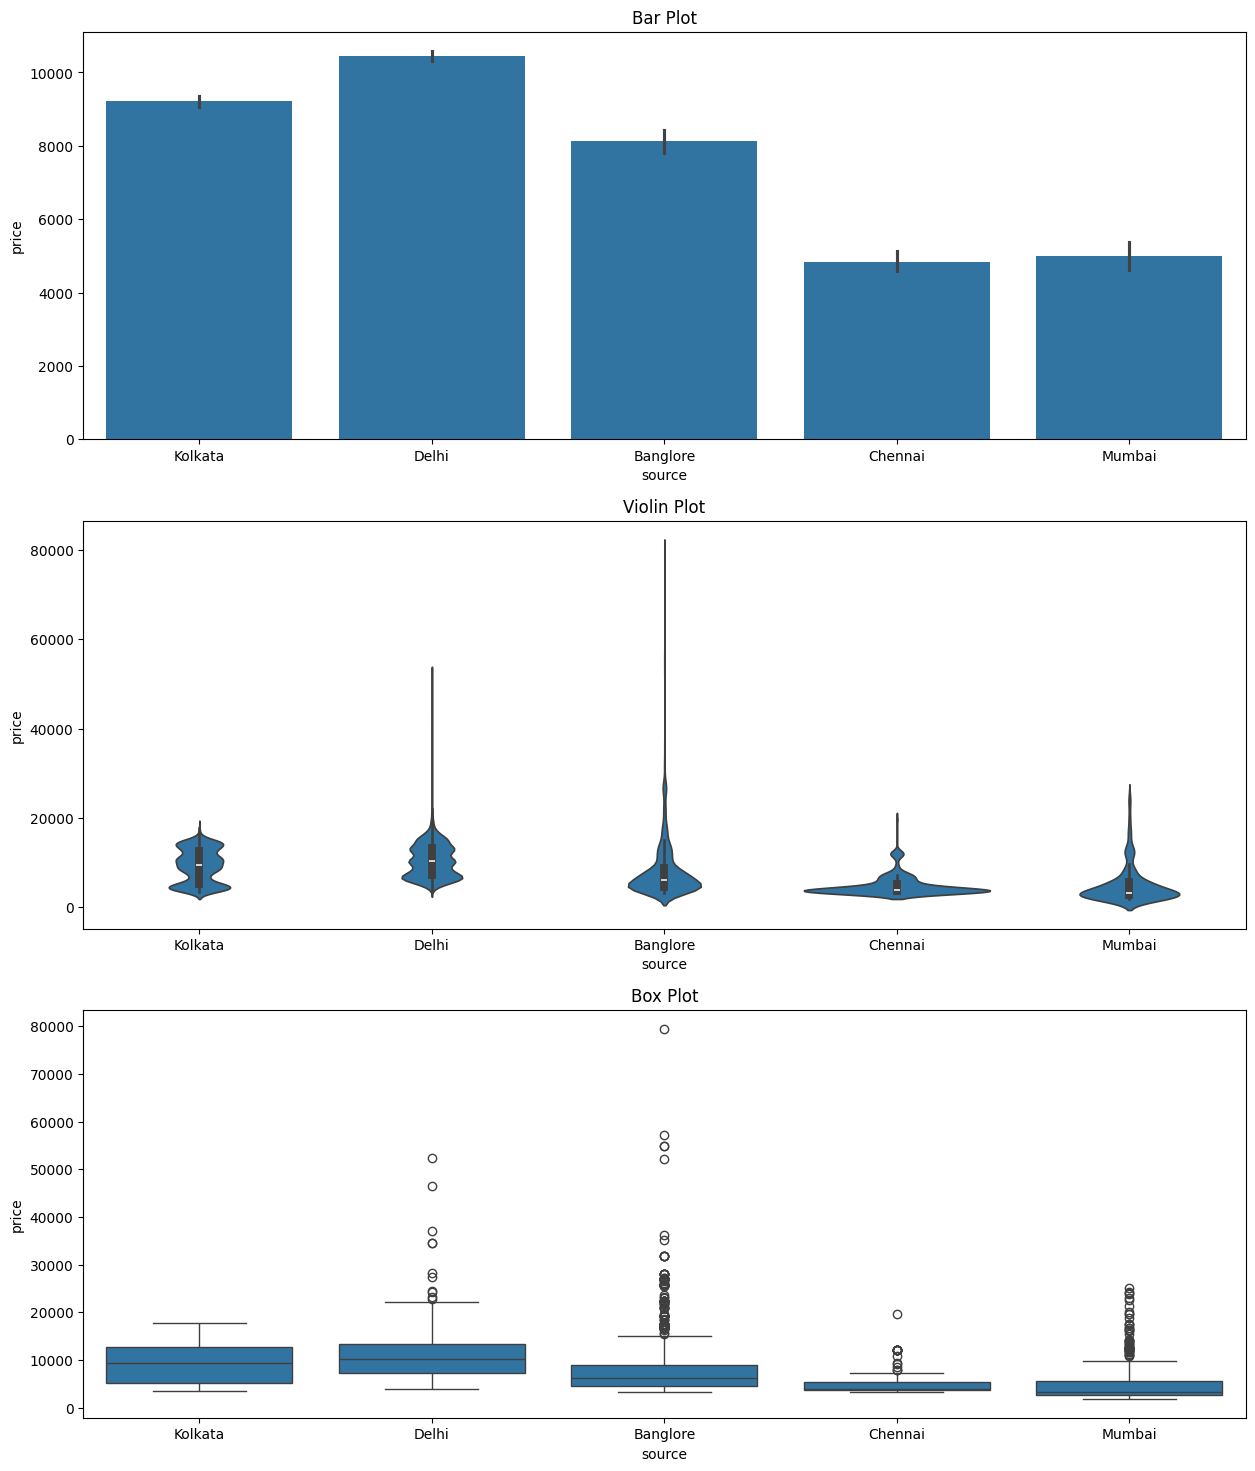

In [22]:
# Bivariate plot between "source" and "price"
num_cat_bivariate_plots(train_fixed,'price','source')

- "source" is a good feature to predict "price" as different category shows variation in price which means they may be associated
- There are some potential outliers

In [23]:
# Anova test
anova_test(train_fixed,'price','source')

Significance Level : 5.0 %
Null Hypothesis : The groups have similar population mean
Alternate Hypothesis : The groups don't have similar population mean
p-value : 1.5399868824268749e-211
Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
CONCLUSION: The variables price and source are associated to each other


### 6.3 Destination

In [24]:
# Category distribution
train_fixed.destination.value_counts(normalize=True)

destination
Cochin       0.412946
Banglore     0.273795
Delhi        0.120033
New Delhi    0.090127
Hyderabad    0.067186
Kolkata      0.035914
Name: proportion, dtype: float64

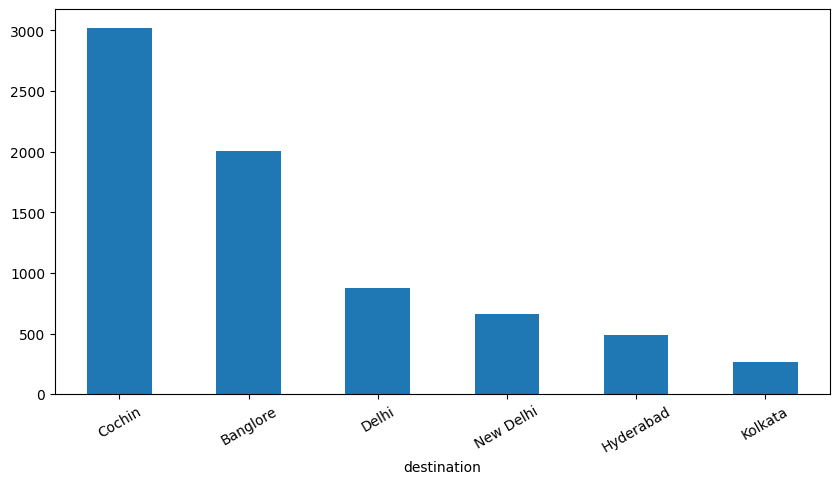

In [25]:
# Univariate plot
cat_univariate_plot(train_fixed,'destination')

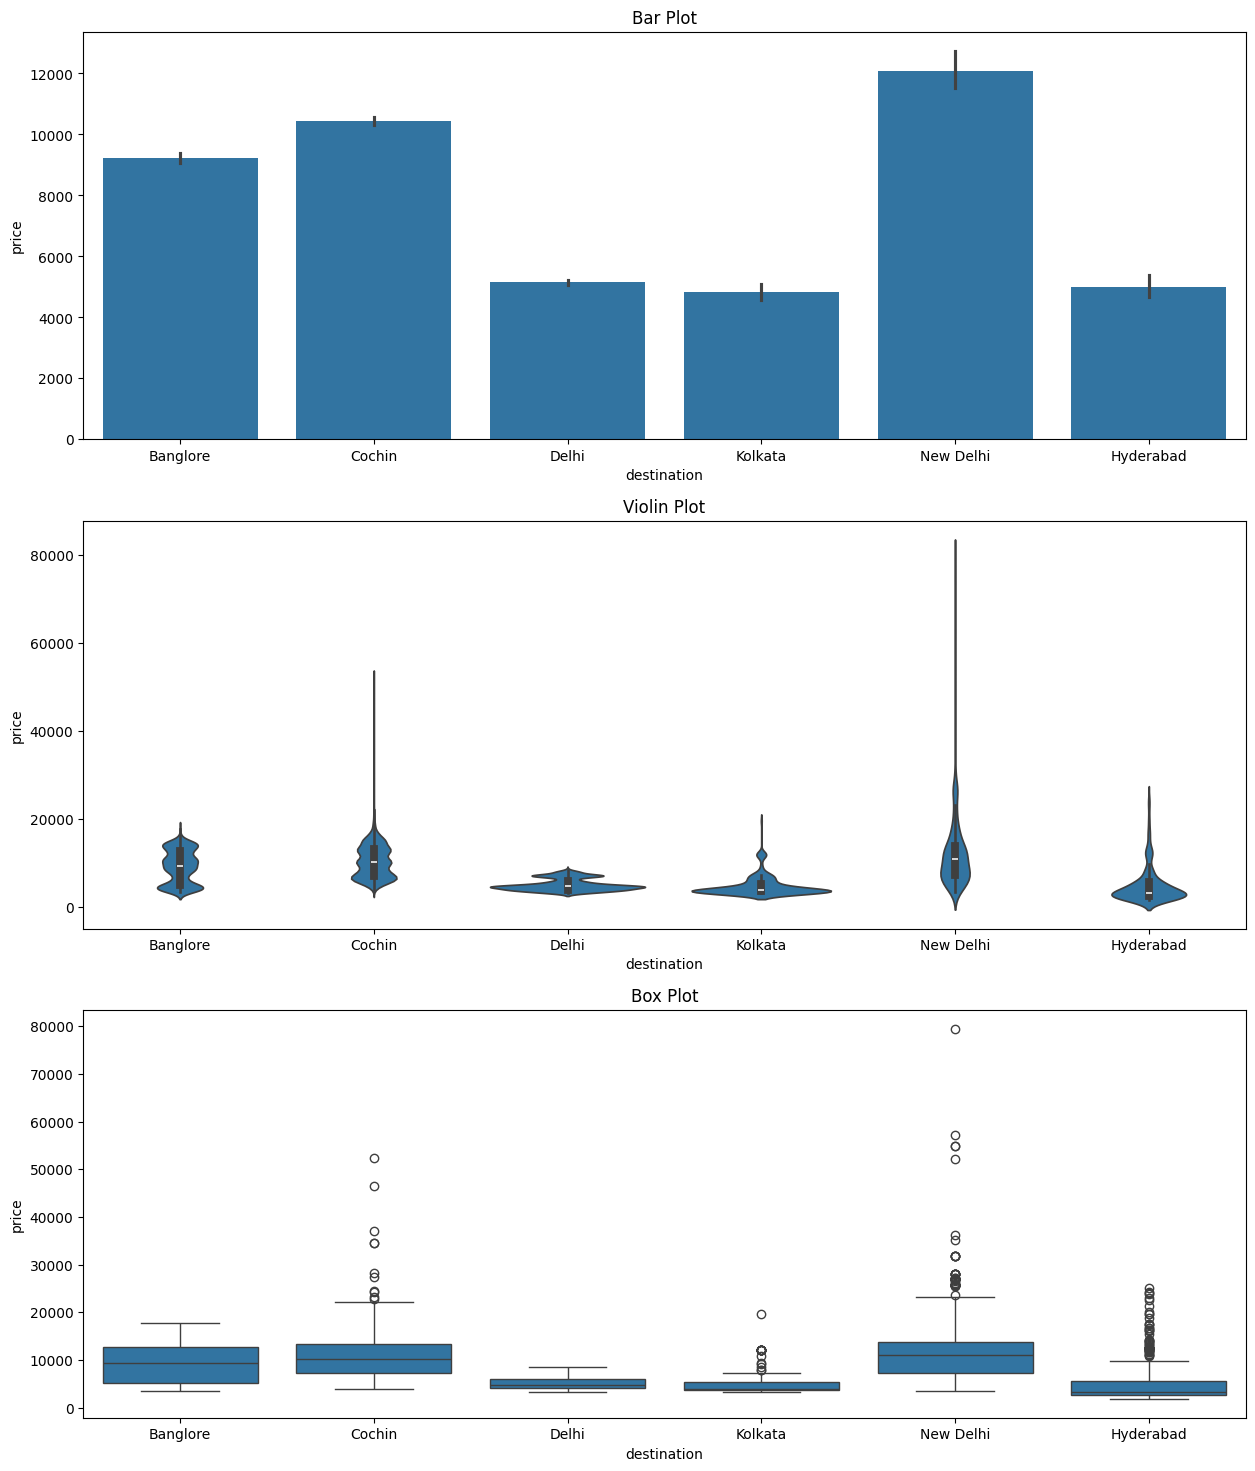

In [26]:
# Bivariate plot between "destination" and "price"
num_cat_bivariate_plots(train_fixed,'price','destination')

- "destination" is a good feature to predict "price" as different category shows variation in price which means they may be associated
- There are some potential outliers

In [27]:
# Anova test
anova_test(train_fixed,'price','destination')

Significance Level : 5.0 %
Null Hypothesis : The groups have similar population mean
Alternate Hypothesis : The groups don't have similar population mean
p-value : 0.0
Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
CONCLUSION: The variables price and destination are associated to each other


### 6.4 Total Stops

In [28]:
# Category distribution
train_fixed.total_stops.value_counts(normalize=True)

total_stops
1    0.537894
0    0.330466
2    0.127953
3    0.003687
Name: proportion, dtype: float64

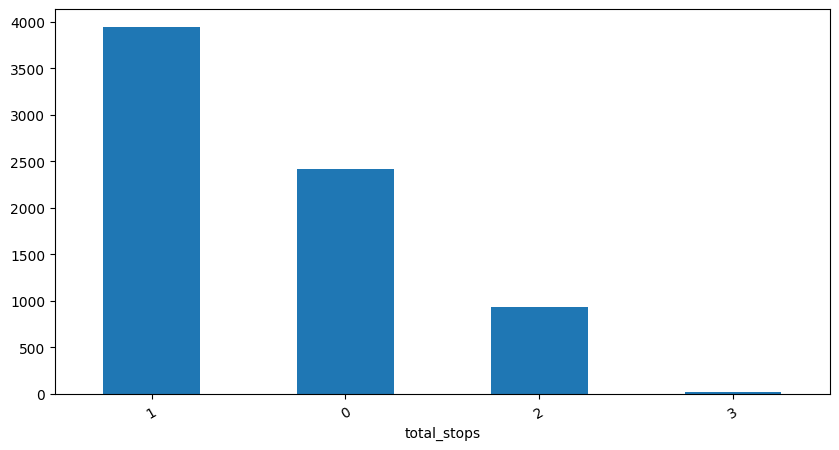

In [29]:
# Univariate plot
cat_univariate_plot(train_fixed,'total_stops')

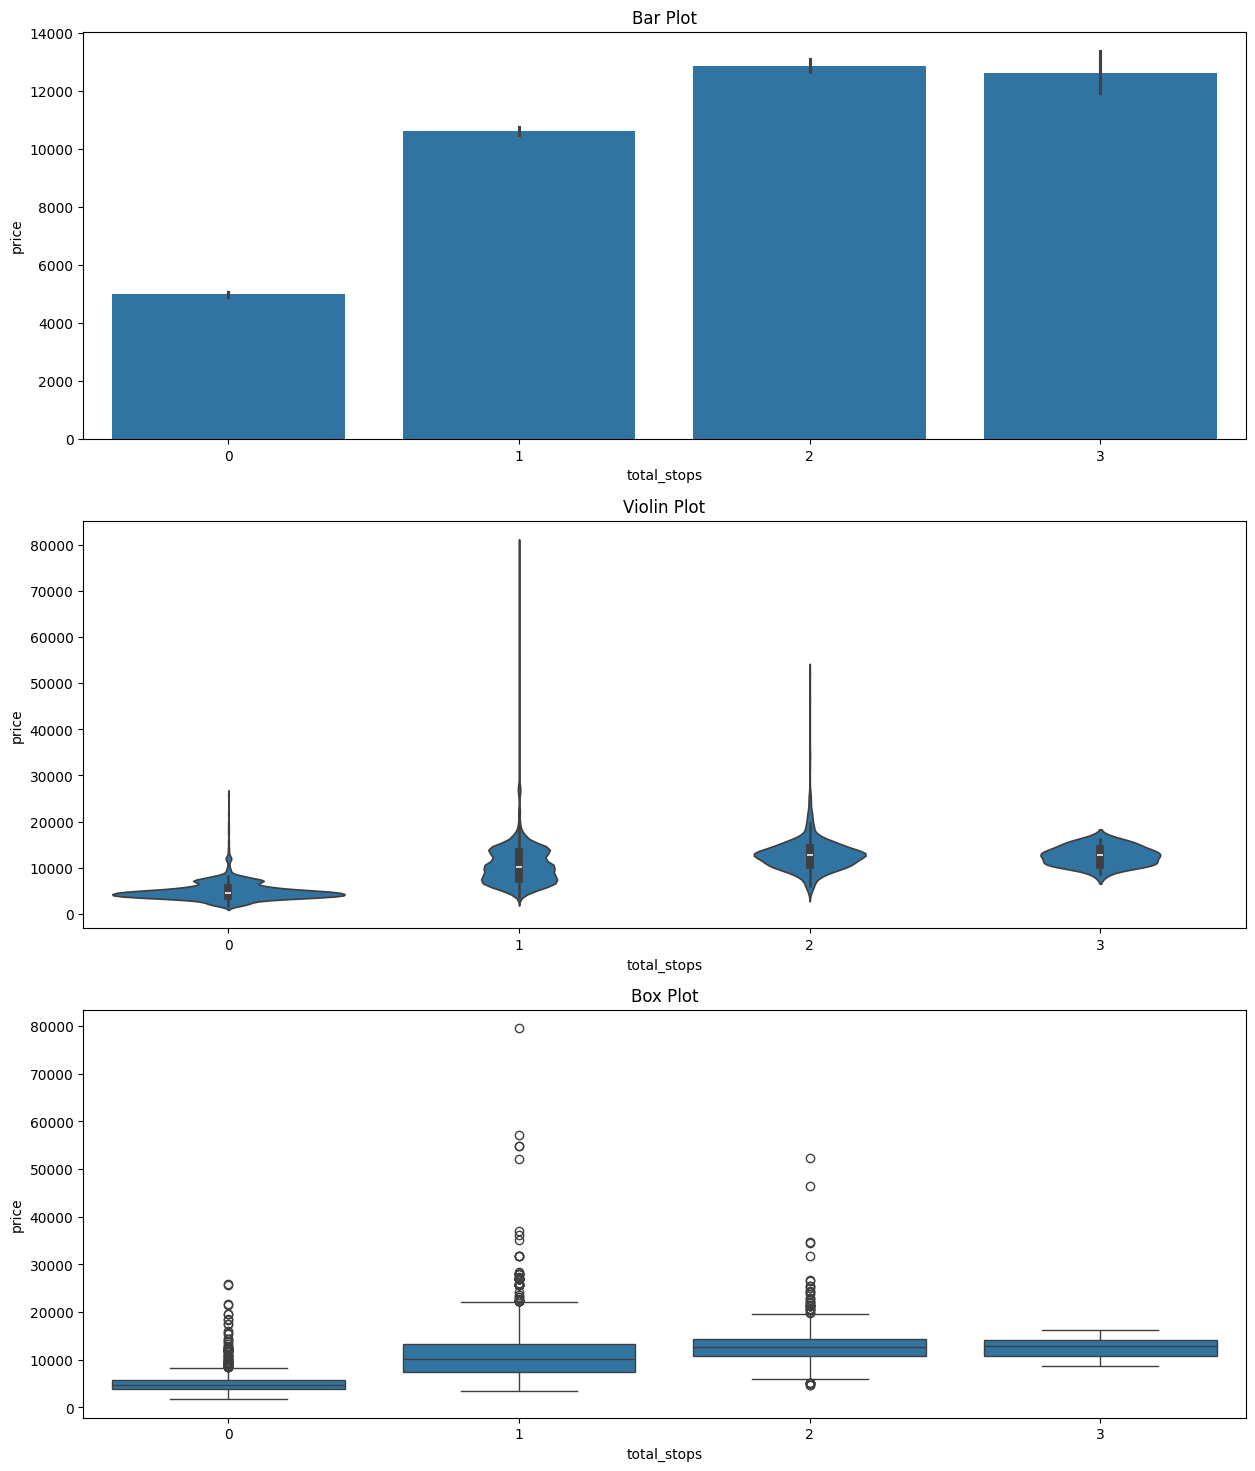

In [30]:
# Bivariate plots between "total_stops" and "price"
num_cat_bivariate_plots(train_fixed,'price','total_stops')

- "total_stops" is a good feature to predict "price" as different category shows variation in price which means they may be associated
- There are some potential outliers

In [31]:
# Anova test
anova_test(train_fixed,'price','total_stops')

Significance Level : 5.0 %
Null Hypothesis : The groups have similar population mean
Alternate Hypothesis : The groups don't have similar population mean
p-value : 0.0
Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
CONCLUSION: The variables price and total_stops are associated to each other


### 6.5 Additional Info

In [32]:
# Category distribution
train_fixed.additional_info.value_counts(normalize=True)

additional_info
No Info                         0.786699
In-flight meal not included     0.179844
No check-in baggage included    0.030042
1 Long layover                  0.001912
Change airports                 0.000683
Business class                  0.000410
2 Long layover                  0.000137
Red-eye flight                  0.000137
1 Short layover                 0.000137
Name: proportion, dtype: float64

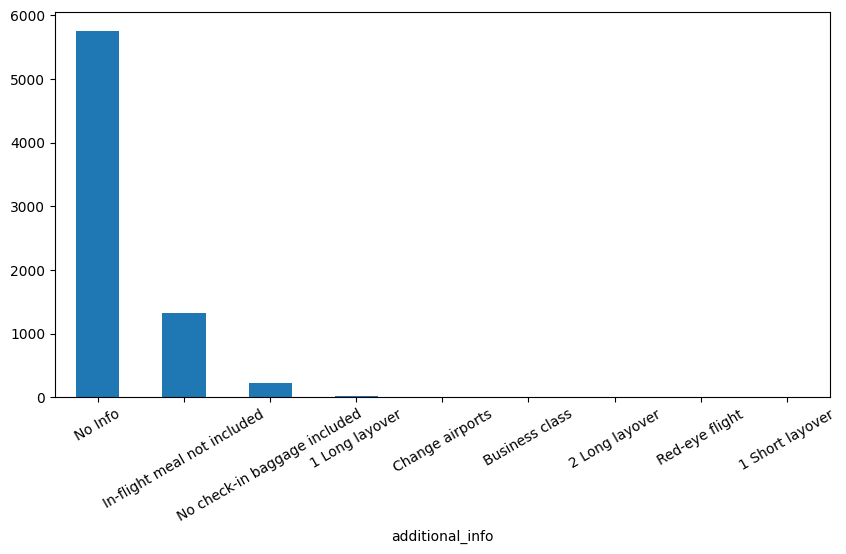

In [33]:
# Univariate plot
cat_univariate_plot(train_fixed,'additional_info')

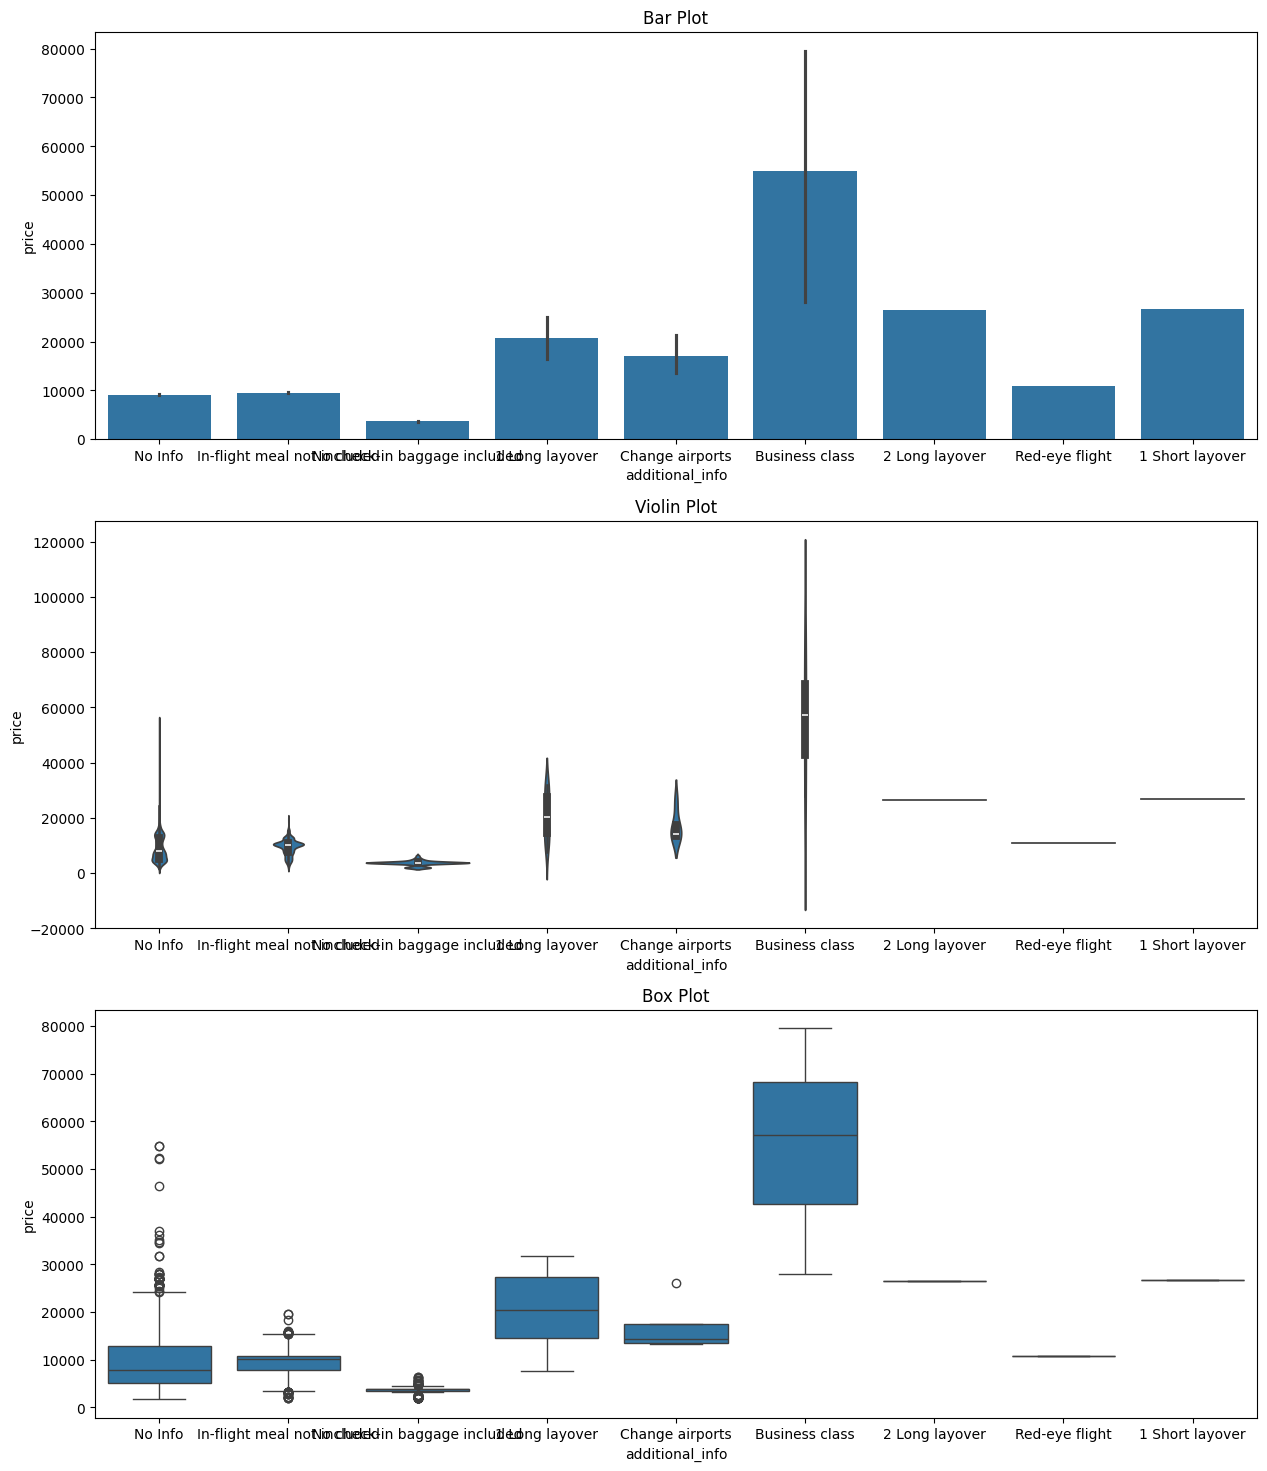

In [34]:
# bivariate plots between "additional info" and "price"
num_cat_bivariate_plots(train_fixed,'price','additional_info')

- "additional info" is a good feature to predict "price" as different category shows variation in price which means they may be associated
- There are some potential outliers

In [35]:
# Anova test
anova_test(train_fixed,'price','additional_info')

Significance Level : 5.0 %
Null Hypothesis : The groups have similar population mean
Alternate Hypothesis : The groups don't have similar population mean
p-value : 2.6926880711035017e-160
Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
CONCLUSION: The variables price and additional_info are associated to each other


### 6.6 Date of Journey

<Axes: xlabel='date_of_journey', ylabel='Count'>

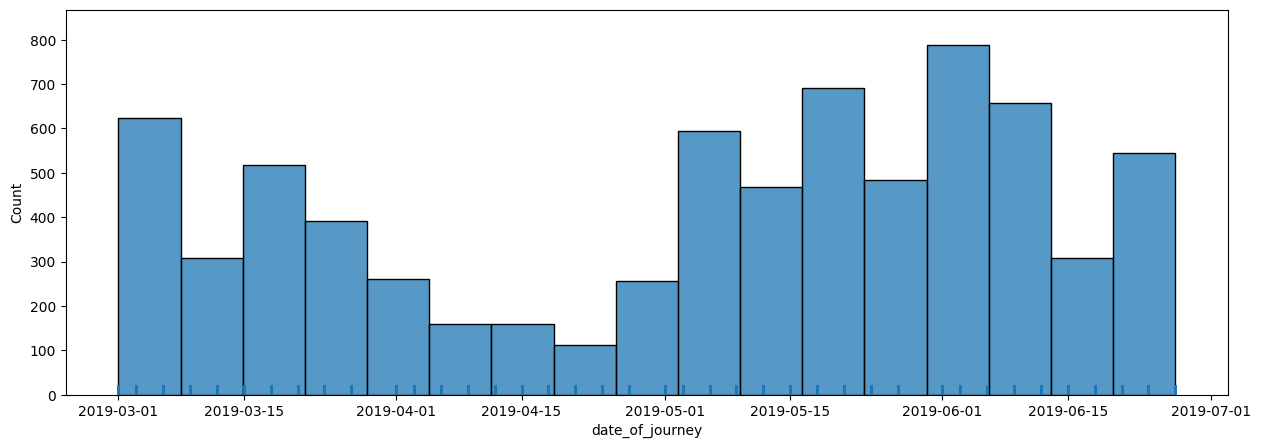

In [36]:
# Univariate plot
plt.figure(figsize=(15,5))
sns.histplot(data=train_fixed,x='date_of_journey')
sns.rugplot(data=train_fixed,x='date_of_journey')

<Axes: xlabel='date_of_journey', ylabel='price'>

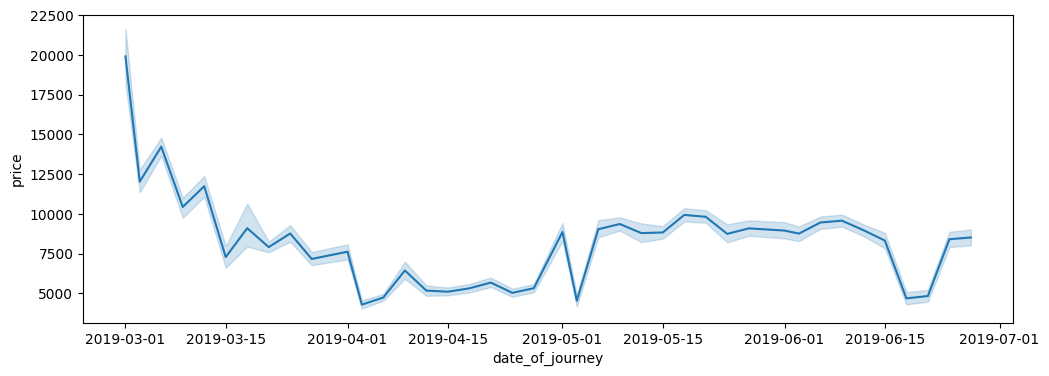

In [37]:
# Bivariate plots between "date of journey" and "price"
plt.figure(figsize=(12,4))
sns.lineplot(data=train_fixed,x='date_of_journey',y='price')

[Text(0, 0, 'March'),
 Text(1, 0, 'April'),
 Text(2, 0, 'May'),
 Text(3, 0, 'June')]

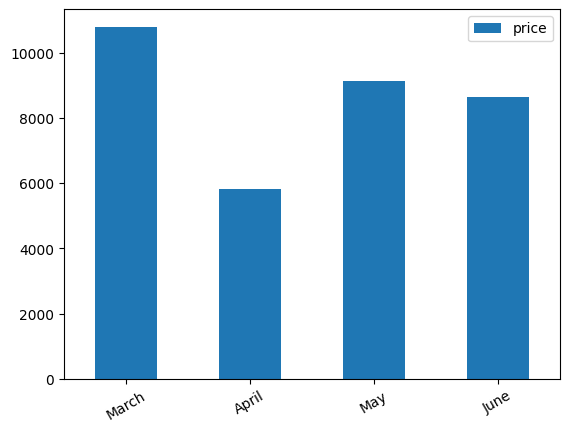

In [38]:
# Vieing price variation by Month
(
    train_fixed
    .groupby(pd.Grouper(key='date_of_journey',freq='M'))
    .price.mean()
    .to_frame()
    .set_axis(['March','April','May','June'],axis=0)
    .plot(kind='bar')
)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(),rotation=30)

In [39]:
# Anova test
(
    train_fixed   
    .assign(date_of_journey = lambda df2 : (                                         # Updating the column        
        np.select([df2.date_of_journey.dt.month==3,
                  df2.date_of_journey.dt.month==4,
                  df2.date_of_journey.dt.month==5],
                  ['March','April','May'],
                  default='June'
                 )
    )
           )
    .pipe(anova_test,'price','date_of_journey')
)

Significance Level : 5.0 %
Null Hypothesis : The groups have similar population mean
Alternate Hypothesis : The groups don't have similar population mean
p-value : 4.0853402259263244e-144
Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
CONCLUSION: The variables price and date_of_journey are associated to each other


### 6.7 Departure Time

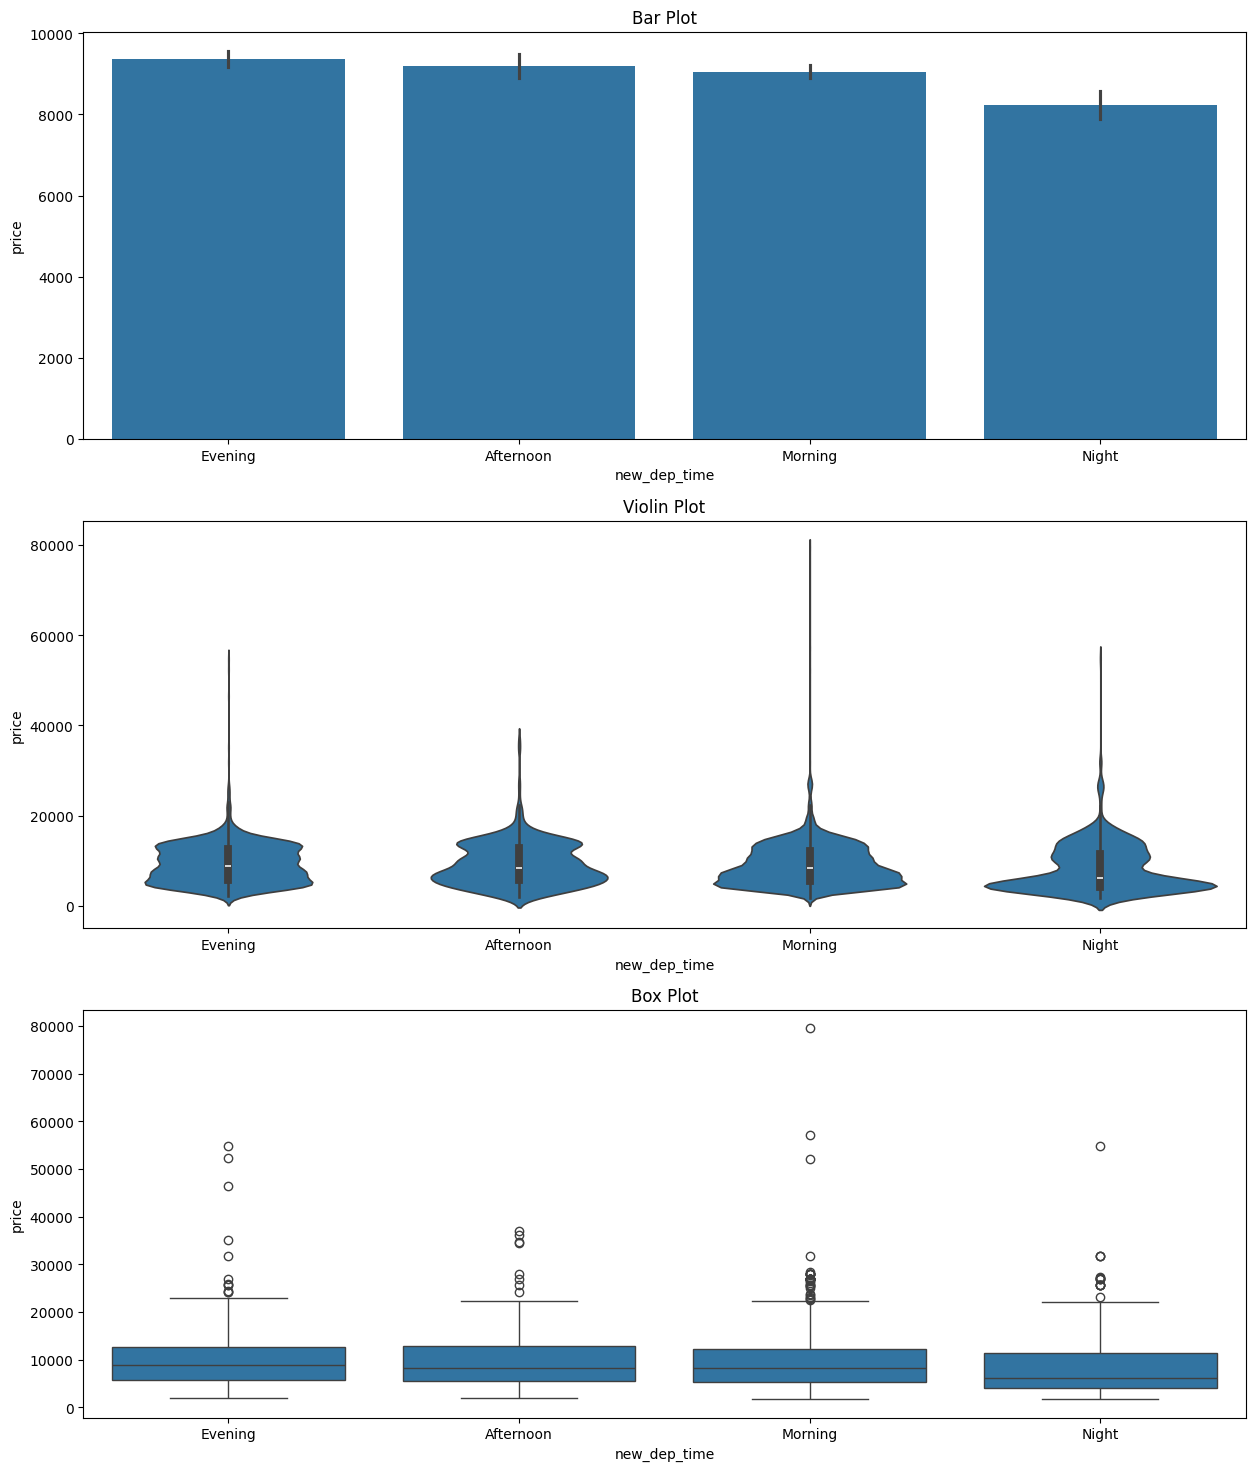

In [40]:
# Bivariate plots between "dep_time" and "price"
(
    train_fixed
    .assign(new_dep_time=lambda df1 : pd.to_datetime(df1.dep_time,dayfirst=True))     # Creating new column 
    .assign(new_dep_time = lambda df2 : (                                             # Updating the column using different day time 
        np.select([df2.new_dep_time.dt.hour.between(4,12,inclusive='left'),
                  df2.new_dep_time.dt.hour.between(12,16,inclusive='left'),
                  df2.new_dep_time.dt.hour.between(16,21,inclusive='left')],
                  ['Morning','Afternoon','Evening'],
                  default='Night'
                 )
    )
           )
    .pipe(num_cat_bivariate_plots,'price','new_dep_time')
)

In [41]:
# Anova test
(
    train_fixed
    .assign(new_dep_time=lambda df1 : pd.to_datetime(df1.dep_time,dayfirst=True))     
    .assign(new_dep_time = lambda df2 : (                                             
        np.select([df2.new_dep_time.dt.hour.between(4,12,inclusive='left'),
                  df2.new_dep_time.dt.hour.between(12,16,inclusive='left'),
                  df2.new_dep_time.dt.hour.between(16,21,inclusive='left')],
                  ['Morning','Afternoon','Evening'],
                  default='Night'
                 )
    )
           )
    .pipe(anova_test,'price','new_dep_time')
)

Significance Level : 5.0 %
Null Hypothesis : The groups have similar population mean
Alternate Hypothesis : The groups don't have similar population mean
p-value : 2.6498017220269216e-08
Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
CONCLUSION: The variables price and new_dep_time are associated to each other


### 6.8 Arrival Time

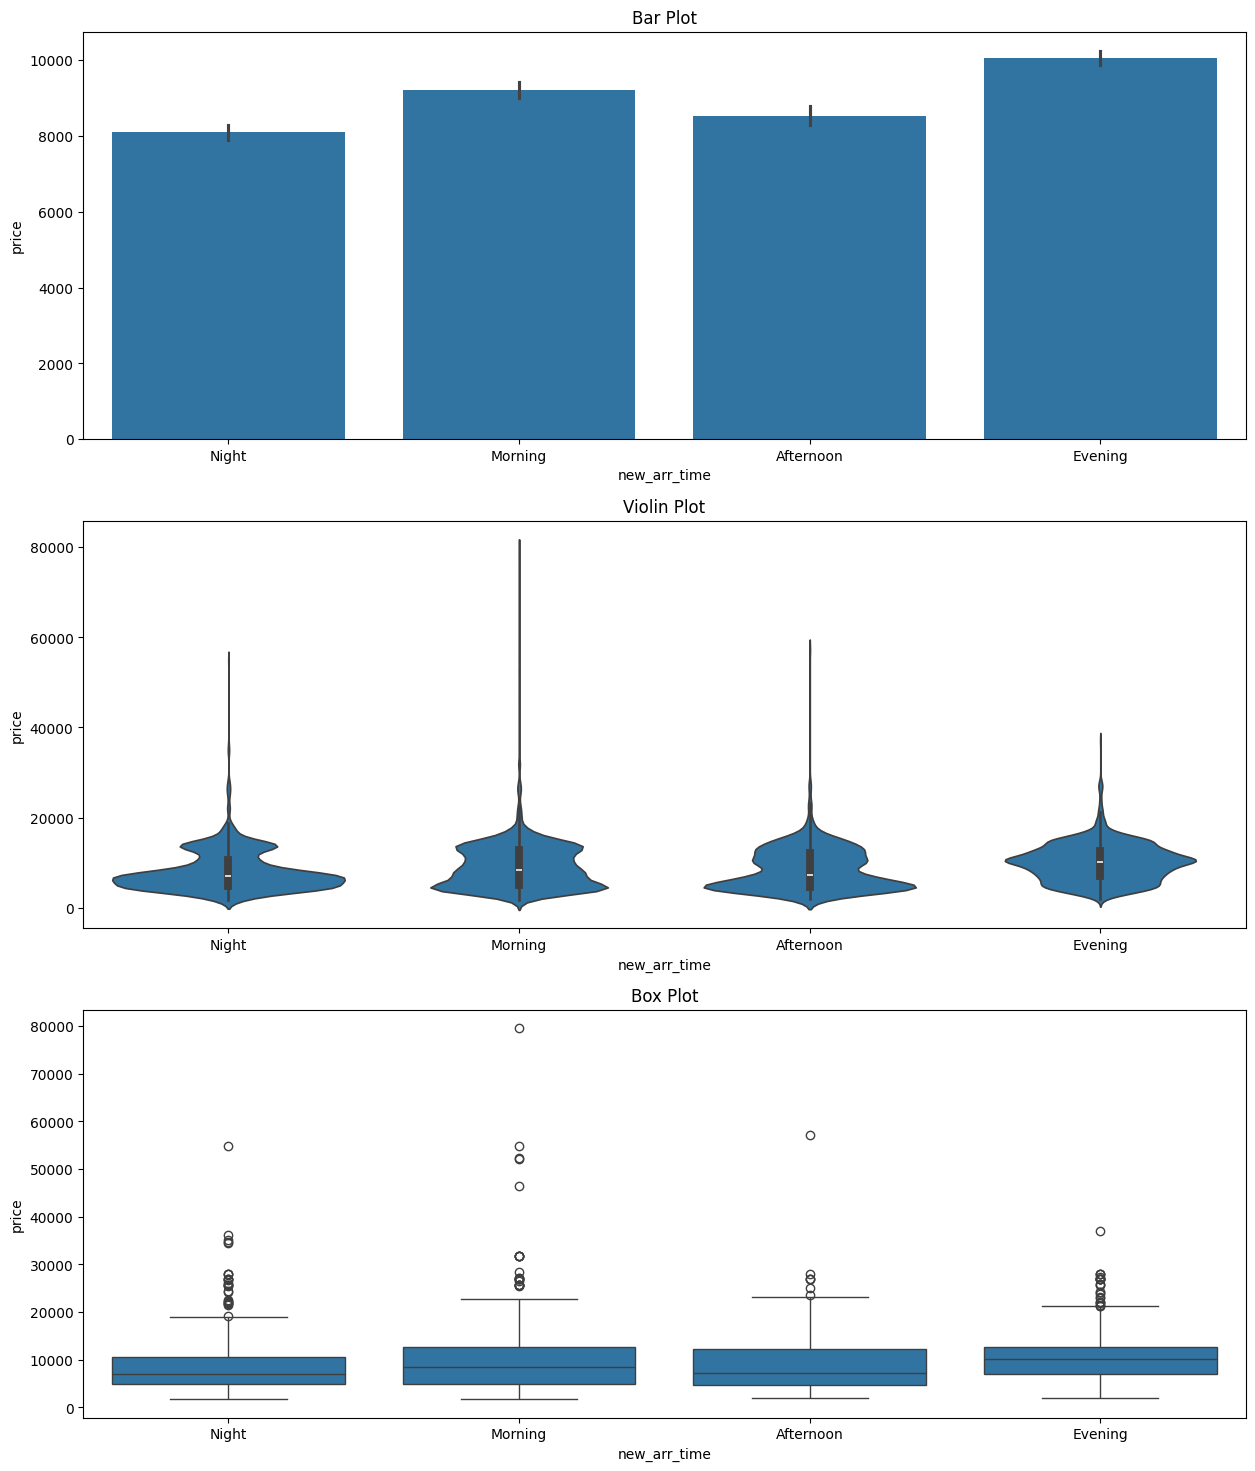

In [42]:
# Bivariate plots between "arrival_time" and "price"
(
    train_fixed
    .assign(new_arr_time=lambda df1 : pd.to_datetime(df1.arrival_time,dayfirst=True))     # Creating new column 
    .assign(new_arr_time = lambda df2 : (                                                # Updating the column using different day time 
        np.select([df2.new_arr_time.dt.hour.between(4,12,inclusive='left'),
                  df2.new_arr_time.dt.hour.between(12,16,inclusive='left'),
                  df2.new_arr_time.dt.hour.between(16,21,inclusive='left')],
                  ['Morning','Afternoon','Evening'],
                  default='Night'
                 )
    )
           )
    .pipe(num_cat_bivariate_plots,'price','new_arr_time')
)

In [43]:
# Anova test
(
    train_fixed
    .assign(new_arr_time=lambda df1 : pd.to_datetime(df1.arrival_time,dayfirst=True))     
    .assign(new_arr_time = lambda df2 : (                                                 
        np.select([df2.new_arr_time.dt.hour.between(4,12,inclusive='left'),
                  df2.new_arr_time.dt.hour.between(12,16,inclusive='left'),
                  df2.new_arr_time.dt.hour.between(16,21,inclusive='left')],
                  ['Morning','Afternoon','Evening'],
                  default='Night'
                 )
    )
           )
    .pipe(anova_test,'price','new_arr_time')
)

Significance Level : 5.0 %
Null Hypothesis : The groups have similar population mean
Alternate Hypothesis : The groups don't have similar population mean
p-value : 4.8630899792620315e-43
Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
CONCLUSION: The variables price and new_arr_time are associated to each other


### 6.9 Duration

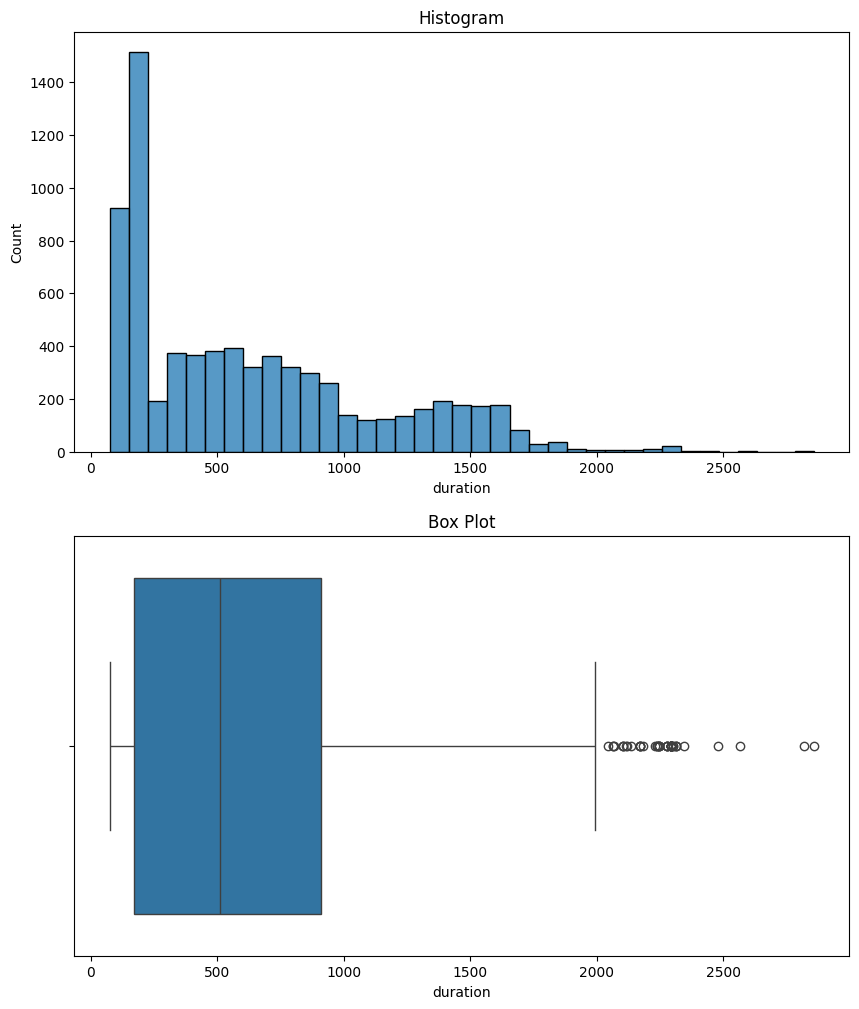

In [44]:
# Univariate plots
num_univariate_plots(train_fixed,'duration')

- As we can see, 'duration' is not normally distributed. We will confirm this by doing Shapiro-Wilk test
- There are potential outliers

In [45]:
# Test for normality
shapiro_wilk_test(train_fixed,'duration')

Significance Level : 0.05
Null Hypothesis : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value : 2.6028153288778086e-58
Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
CONCLUSION: We conclude that the data sample is not normally distributed


<Axes: xlabel='duration', ylabel='price'>

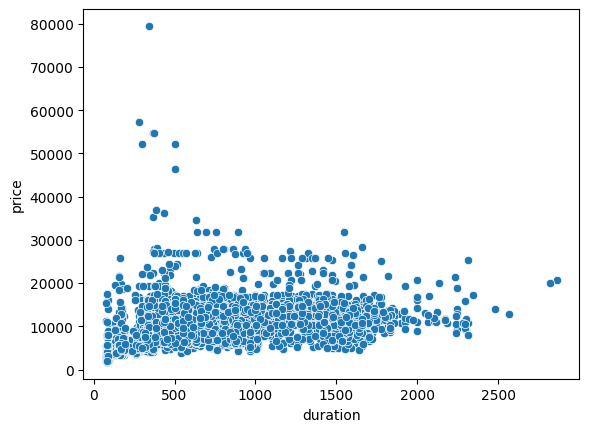

In [46]:
# Bivariate plot between "duration" and "price"
sns.scatterplot(data=train_fixed,x='duration',y='price')

- The relationship is quite a bit linear which means they may be correlated. We will confirm this by doing hypothesis test
- There are some extreme values present

In [47]:
# Spearman test for Correlation analysis
spearman_test(train_fixed,'price','duration')

Significance Level : 0.05
Null Hypothesis : The samples are uncorrelated
Alternate Hypothesis : The samples are correlated
p-value : 0.0
Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
CONCLUSION: The variables price and duration are correlated


- Here we have performed Spearman test because our data is not normally distributed